In [1]:
%matplotlib inline

import json
import glob
import re
import itertools

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
with open('../../pair_counts.json') as f:
    total_read_counts = pd.Series({k: v/2e6 for k,v in json.load(f).items()})

In [3]:
with open('../../mean_spikein_counts.json') as f:
    spike_counts = pd.Series(json.load(f))

In [4]:
peak_locations = pd.read_csv('../../peak_calls/combined_bam_peaks/dmso_3_vs_input_peaks.broadPeak', 
                             sep = '\t', names = ('chr', 'start', 'end'), usecols = ('chr', 'start', 'end'))


In [5]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str), sep='-'), sep=':')

In [6]:
peak_locations['ucsc_index'] = ucsc_index(peak_locations)

# Load raw count data over peaks

In [7]:
count_files = glob.glob('../../count_statistics/new_macs_calls/dmso/*.cov')

In [8]:
bed_names = ['chr', 'start', 'end']

count_data_plus = {}
count_data_minus = {}

for f in count_files:
    if '.p.cov' in f:
        sample_name = re.findall('/([^/]+)\.[pm]\.cov', f)[0]
        
        plus_strand_values = pd.read_csv(f, sep='\t', names = bed_names + [sample_name])
        plus_strand_values.set_index(ucsc_index(plus_strand_values), inplace=True)
        minus_strand_values =  pd.read_csv(f.replace('.p.cov', '.m.cov'), sep='\t', names = bed_names + [sample_name])
        minus_strand_values.set_index(ucsc_index(minus_strand_values), inplace=True)
        count_data_plus[sample_name] = plus_strand_values[sample_name]
        count_data_minus[sample_name] = minus_strand_values[sample_name]

In [9]:
count_data_minus = pd.DataFrame(count_data_minus)
count_data_plus = pd.DataFrame(count_data_plus)

In [10]:
count_data_minus = count_data_minus[count_data_minus.index.isin(peak_locations.ucsc_index)]
count_data_plus = count_data_plus[count_data_plus.index.isin(peak_locations.ucsc_index)]

In [11]:
len(count_data_plus), len(peak_locations)

(81151, 81151)

In [12]:
ip_cols = list('_'.join(i) for i in itertools.product(['dmso', 'drb', 'gl3'], ['2', '3']))
rh_cols = [i + '_rh' for i in ['drb', 'gl3']]

# Find areas of high strand bias

In [13]:
strand_bias = ((count_data_plus - count_data_minus)/(count_data_plus + count_data_minus))[ip_cols]

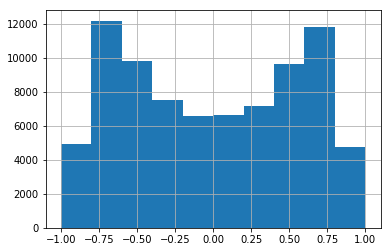

In [14]:
strand_bias.mean(axis=1).hist()

In [15]:
has_bias = strand_bias.mean(axis=1).abs() > 1/3

In [16]:
count_data_both = count_data_minus + count_data_plus

# Find RNase H sensitive areas 

In [17]:
mean_rh_rpm = (count_data_both[rh_cols] / total_read_counts[rh_cols]).mean(axis=1)

In [18]:
mean_ip_rpm = (count_data_both[ip_cols] / total_read_counts[ip_cols]).mean(axis=1)

In [19]:
rh_sensitive = ((mean_ip_rpm/2) > mean_rh_rpm)

In [20]:
len(mean_ip_rpm)

81151

In [21]:
(has_bias & rh_sensitive).sum()

18715

# Output bed file

In [27]:
coords = count_data_both.index.str.extract('(.*):(\d+)-(\d+)', expand=True).rename(columns={0:'chr', 1:'start', 2:'end'})
coords = coords.set_index(ucsc_index(coords))

In [28]:
coords['strand'] = np.nan
coords.loc[~has_bias, 'strand'] = '.'
coords.loc[(strand_bias.mean(axis=1) > 0.5), 'strand'] = '-' # Will annotate according to direction of "transcription" implied by R-loop
coords.loc[(strand_bias.mean(axis=1) < 0.5), 'strand'] = '+'

coords['name'] = '.'
coords['value'] = '.'

In [29]:
subset = coords.loc[(has_bias & rh_sensitive), ]

In [30]:
def genome_length(subset):
    return pd.to_numeric(coords[subset].end) - pd.to_numeric(coords[subset].start)

In [31]:
genome_length(has_bias).sum()/1e6, genome_length(rh_sensitive).sum()/1e6, genome_length(has_bias & rh_sensitive).sum()/1e6

(323.428614, 229.355111, 206.659746)

In [32]:
len(coords), has_bias.sum(), rh_sensitive.sum(), (has_bias & rh_sensitive).sum()

(81151, 58469, 22671, 18715)

In [33]:
(pd.to_numeric(coords.end) - pd.to_numeric(coords.start)).sum()

384921831

In [25]:
(pd.to_numeric(subset.end) - pd.to_numeric(subset.start)).sum()

206659746

In [26]:
bed = coords.loc[(has_bias & rh_sensitive),'chr start end name value strand'.split()]

In [27]:
bed['length'] = pd.to_numeric(bed.end) - pd.to_numeric(bed.start)

In [28]:
bed.length.max()

228244

In [29]:
len(bed)

18715

In [30]:
(coords
 .loc[(has_bias & rh_sensitive),'chr start end name value strand'.split()]
 .sort_values(['chr', 'start', 'end'])
 .to_csv('../../peak_calls/combined_bam_peaks/dmso_broad_annotated.bed',
          index=False, header=False, sep='\t')
)

# Overlap with gene file

In [31]:
!mkdir ../../peak_calls/combined_bam_peaks/gene_overlap

mkdir: ../../peak_calls/combined_bam_peaks/gene_overlap: File exists


In [32]:
!head ../../peak_calls/combined_bam_peaks/gl3_broad_annotated.bed

chr1	100012840	100014213	.	.	+
chr1	100019476	100022850	.	.	+
chr1	100033590	100040859	.	.	+
chr1	100139451	100152201	.	.	+
chr1	100187056	100195372	.	.	-
chr1	100278113	100279378	.	.	+
chr1	100280521	100280995	.	.	+
chr1	100298480	100299137	.	.	+
chr1	100878009	100890977	.	.	-
chr1	100892070	100894766	.	.	-


In [33]:
!bedtools slop -b 500 -g ../../hg38.chrom.sizes -i /Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical.bed > /Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_expanded.bed 
!bedtools intersect -wao -b /Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_expanded.bed -a ../../peak_calls/combined_bam_peaks/dmso_broad_annotated.bed > ../../peak_calls/combined_bam_peaks/gene_overlap/dmso_overlap.tsv


In [34]:
!head ../../peak_calls/final_peaks/gene_overlap/gl3_ovelap.tsv

chr1	999593	1000012	.	.	-	chr1	998463	1000611	ENST00000304952.10	419
chr1	1329697	1330567	.	.	-	.	-1	-1	.	0
chr1	1330839	1336441	.	.	-	chr1	1330813	1335806	ENST00000339381.5	4967
chr1	1330839	1336441	.	.	-	chr1	1334775	1349612	ENST00000378891.9	1666
chr1	1495885	1496644	.	.	+	chr1	1471268	1496702	ENST00000308647.7	759
chr1	1889699	1891063	.	.	-	chr1	1890970	1893158	ENST00000412228.1	93
chr1	1889699	1891063	.	.	-	chr1	1784784	1891617	ENST00000610897.4	1364
chr1	2185988	2188552	.	.	-	.	-1	-1	.	0
chr1	2228718	2232166	.	.	+	chr1	2228194	2310619	ENST00000378536.4	3448
chr1	2375912	2388528	.	.	-	chr1	2320752	2392207	ENST00000378531.7	12616


In [35]:
overlaps = pd.read_csv('../../peak_calls/combined_bam_peaks/gene_overlap/dmso_overlap.tsv', 
                       names = 'chr start end name value strand gene_chr gene_start gene_end transcript_id overlap'.split(),
                       usecols = 'chr start end strand transcript_id'.split(), sep='\t'
                      )

gene_data = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_GENCODE_v29.tsv', sep='\t',
                        names = 'transcript_id chr strand start end'.split(), usecols = 'transcript_id chr strand start end'.split(),
                        skiprows =1
                       )
overlaps = overlaps.merge(gene_data, on = 'transcript_id', suffixes=['', '_gene'], how = 'left')

In [36]:
overlaps['min_dist_to_start'] = (overlaps[['start', 'end']].subtract(overlaps.start_gene, axis=0)).abs().min(axis=1)
overlaps['min_dist_to_end'] = (overlaps[['start', 'end']].subtract(overlaps.end_gene, axis=0)).abs().min(axis=1)

In [37]:
# Calculate min distance from the ends of each interval to the promoter or terminator of its overlapping gene
overlaps['min_dist_to_prom'] = np.nan
overlaps['min_dist_to_term'] = np.nan

overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_prom'] = overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_start']
overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_term'] = overlaps.loc[overlaps.strand_gene == '+', 'min_dist_to_end']

overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_prom'] = overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_end']
overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_term'] = overlaps.loc[overlaps.strand_gene == '-', 'min_dist_to_start']

In [38]:
# If the region overlaps the promoter or terminator, set the min distance to 0
overlaps.loc[(overlaps.strand_gene == '+') & 
             (overlaps.start < overlaps.start_gene) & 
             (overlaps.end > overlaps.start_gene), 'min_dist_to_prom'] = 0

overlaps.loc[(overlaps.strand_gene == '-') & 
             (overlaps.start < overlaps.end_gene) & 
             (overlaps.end > overlaps.end_gene), 'min_dist_to_prom'] = 0

overlaps.loc[(overlaps.strand_gene == '-') & 
             (overlaps.start < overlaps.start_gene) & 
             (overlaps.end > overlaps.start_gene), 'min_dist_to_term'] = 0

overlaps.loc[(overlaps.strand_gene == '+') & 
             (overlaps.start < overlaps.end_gene) & 
             (overlaps.end > overlaps.end_gene), 'min_dist_to_term'] = 0

In [39]:
overlaps['ucsc_name'] = ucsc_index(overlaps)

In [40]:
distances_to_ends = (overlaps
                     .groupby('ucsc_name')
                     [['min_dist_to_term', 'min_dist_to_prom']]
                     .min())

In [41]:
terminator_dist = 3000
promoter_dist = 3000

annotations = {}
annotations['promoter_alone'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term > terminator_dist) & 
                                                   (distances_to_ends.min_dist_to_prom <= promoter_dist))].index)
annotations['terminator_alone'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term <= terminator_dist) & 
                                                     (distances_to_ends.min_dist_to_prom > promoter_dist))].index)
annotations['gene_body'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term > terminator_dist) & 
                                              (distances_to_ends.min_dist_to_prom > promoter_dist))].index)
annotations['promoter_and_terminator'] = set(distances_to_ends[((distances_to_ends.min_dist_to_term <= terminator_dist) & 
                                                            (distances_to_ends.min_dist_to_prom <= promoter_dist))].index)
annotations['intergenic'] = set(overlaps[overlaps.chr_gene.isnull()].ucsc_name)


In [42]:
peak_percents = {k:len(v)/sum(len(i) for i in annotations.values()) for k, v in annotations.items()}

In [67]:
total_bases_hg38 = 3209286105
bases_per_region = {
    'promoter_alone': 337026562 - 179514614,
    'terminator_alone': 337026562 - 179514614,
    'promoter_and_terminator': 179514614,
    'gene_body': 1406465624
}
genome_percents = {k: v/total_bases_hg38 for k,v in bases_per_region.items()}
genome_percents['intergenic'] = 1 - sum(genome_percents.values())

In [68]:
percent_data = (pd.DataFrame({
    'Genome': genome_percents,
    'Peaks': peak_percents
})
    .reset_index()
    .melt(id_vars = 'index')
    .rename(columns = {'index': 'Region',
                       'variable': 'Type',
                       'value': 'Percent of regions'
                      }))
                      

In [69]:
percent_data

,Region,Type,Percent of regions
0,gene_body,Genome,0.438249
1,intergenic,Genome,0.407655
2,promoter_alone,Genome,0.049080
3,promoter_and_terminator,Genome,0.055936
4,terminator_alone,Genome,0.049080
5,gene_body,Peaks,0.567268
6,intergenic,Peaks,0.068186
7,promoter_alone,Peaks,0.068127
8,promoter_and_terminator,Peaks,0.171589
9,terminator_alone,Peaks,0.124830


In [70]:
percent_data

,Region,Type,Percent of regions
0,gene_body,Genome,0.438249
1,intergenic,Genome,0.407655
2,promoter_alone,Genome,0.049080
3,promoter_and_terminator,Genome,0.055936
4,terminator_alone,Genome,0.049080
5,gene_body,Peaks,0.567268
6,intergenic,Peaks,0.068186
7,promoter_alone,Peaks,0.068127
8,promoter_and_terminator,Peaks,0.171589
9,terminator_alone,Peaks,0.124830


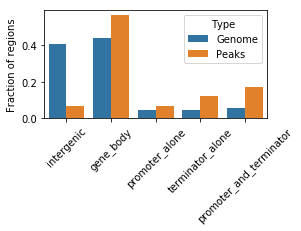

In [71]:
fig, ax = plt.subplots(figsize=(4,2))
sns.barplot(
     x = 'Region',
     hue = 'Type',
     order = ['intergenic', 'gene_body', 'promoter_alone', 'terminator_alone', 'promoter_and_terminator'],
     y = 'Percent of regions',
     data = percent_data)
ax.set_xlabel('')
ax.set_ylabel('Fraction of regions')
ticks = ax.xaxis.get_ticklabels()
for t in ticks:
    t.set_rotation(45)
fig.savefig('peak_locations.svg')

In [58]:
genes = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical.bed',
                    names = ('chr', 'start', 'end', 'name'), sep = '\t'
                   )

In [59]:
genes.head()

,chr,start,end,name
0,chr1,11868,14409,ENST00000456328.2
1,chr1,14403,29570,ENST00000488147.1
2,chr1,17368,17436,ENST00000619216.1
3,chr1,29553,31097,ENST00000473358.1
4,chr1,30365,30503,ENST00000607096.1


In [60]:
genes['length'] = genes.end - genes.start
lengths = (genes.length - 7000)
lengths[lengths < 0] = 0

In [64]:
lengths.sum()

1406465624

In [43]:
overlaps['site_annotation'] = np.nan
overlaps.loc[overlaps.ucsc_name.isin(annotations['promoter_alone']), 'site_annotation'] = 'promoter_alone'
overlaps.loc[overlaps.ucsc_name.isin(annotations['terminator_alone']), 'site_annotation'] = 'terminator_alone'
overlaps.loc[overlaps.ucsc_name.isin(annotations['gene_body']), 'site_annotation'] = 'gene_body'
overlaps.loc[overlaps.ucsc_name.isin(annotations['promoter_and_terminator']), 'site_annotation'] = 'promoter_and_terminator'
overlaps.loc[overlaps.ucsc_name.isin(annotations['intergenic']), 'site_annotation'] = 'intergenic'


In [44]:
coords['ucsc'] = ucsc_index(coords)

In [45]:
coords['site_annotation'] = np.nan
coords.loc[coords.ucsc.isin(annotations['promoter_alone']), 'site_annotation'] = 'promoter_alone'
coords.loc[coords.ucsc.isin(annotations['terminator_alone']), 'site_annotation'] = 'terminator_alone'
coords.loc[coords.ucsc.isin(annotations['gene_body']), 'site_annotation'] = 'gene_body'
coords.loc[coords.ucsc.isin(annotations['promoter_and_terminator']), 'site_annotation'] = 'promoter_and_terminator'
coords.loc[coords.ucsc.isin(annotations['intergenic']), 'site_annotation'] = 'intergenic'

In [47]:
filtered = coords[(rh_sensitive & has_bias)]

In [48]:
filtered.to_csv('../../peak_calls/final_peaks/dmso_consensus_annotated.tsv')

In [49]:
!head ../../peak_calls/final_peaks/dmso_consensus_annotated.tsv

chr,chr,start,end,strand,name,value,ucsc,site_annotation
chr1:1328847-1337532,chr1,1328847,1337532,-,.,.,chr1:1328847-1337532,promoter_and_terminator
chr1:1829772-1830294,chr1,1829772,1830294,-,.,.,chr1:1829772-1830294,gene_body
chr1:1856627-1858640,chr1,1856627,1858640,-,.,.,chr1:1856627-1858640,gene_body
chr1:2357985-2358619,chr1,2357985,2358619,-,.,.,chr1:2357985-2358619,gene_body
chr1:2375637-2389224,chr1,2375637,2389224,-,.,.,chr1:2375637-2389224,promoter_alone
chr1:2390322-2390795,chr1,2390322,2390795,+,.,.,chr1:2390322-2390795,promoter_alone
chr1:3729913-3747766,chr1,3729913,3747766,-,.,.,chr1:3729913-3747766,promoter_and_terminator
chr1:3828238-3829210,chr1,3828238,3829210,-,.,.,chr1:3828238-3829210,gene_body
chr1:3830843-3835097,chr1,3830843,3835097,-,.,.,chr1:3830843-3835097,gene_body
